## 2. Modeling
we showed how to use siGra step by step

In [1]:
import argparse
import pandas as pd
import os
import scanpy as sc
from sklearn.metrics.cluster import adjusted_rand_score
import numpy as np
import cv2
import torchvision.transforms as transforms
from utils import Cal_Spatial_Net, Stats_Spatial_Net, _hungarian_match, seed_everything
from train_transformer import train_nano_fov, test_nano_fov
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt
import random
from scipy.optimize import linear_sum_assignment

os.environ['PYTHONHASHSEED'] = '1234'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

### 2.1 define hyperparameters

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--root', type=str, default='../dataset/nanostring')
parser.add_argument('--epochs', type=int, default=2000)
parser.add_argument('--id', type=str, default='fov1')
parser.add_argument('--img_name', type=str, default='F001')
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument('--save_path', type=str, default='../checkpoint/nanostring_all')
parser.add_argument('--ncluster', type=int, default=8)
parser.add_argument('--repeat', type=int, default=1)
parser.add_argument('--use_gray', type=float, default=0)
parser.add_argument('--test_only', type=int, default=1)
parser.add_argument('--pretrain', type=str, default='final.pth')
parser.add_argument('--cluster_method', type=str, default='leiden')
# in jupyter, we nned to add args=[]
# if you run in scripts, you can run: "opt = parser.parse_args()"
opt = parser.parse_args(args=[])

### 2.2 build SNN for each fov
here we used fov1 as an example

../dataset/nanostring/fov1/CellComposite_F001.jpg
(3648, 5472)
------Calculating spatial graph...
The graph contains 25140 edges, 4966 cells.
5.0624 neighbors per cell on average.


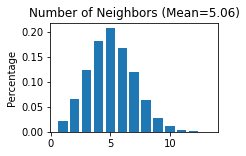

In [3]:
root = opt.root
img_name = 'F001'
id = 'fov1'
adata = sc.read(os.path.join(root, id, 'sampledata.h5ad'))
adata.var_names_make_unique()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

ncluster = len(set(adata.obs['merge_cell_type']))

print(os.path.join(root, id, 'CellComposite_%s.jpg'%(img_name)))
img = cv2.imread(os.path.join(root, id, 'CellComposite_%s.jpg'%(img_name)))
height, width, c = img.shape
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
overlay = cv2.imread(os.path.join(root, id, 'CompartmentLabels_%s.tif'%(img_name)))
overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2GRAY)
print(overlay.shape)

if opt.use_gray:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
transform = transforms.ToTensor()
img = transform(img)
overlay = transform(overlay)

patchs = []
w, h = 60, 60
    
for coor in adata.obsm['spatial']:
    x, y = coor
    img_p = img[:, int(y-h):int(y+h), int(x-w): int(x+w)]

    patchs.append(img_p.flatten()) # 4 * h * w
patchs = np.stack(patchs)


df = pd.DataFrame(patchs, index=adata.obs.index)
adata.obsm['imgs'] = df

Cal_Spatial_Net(adata, rad_cutoff=80)
Stats_Spatial_Net(adata)

### 2.3 fixed seed

In [4]:
seed = opt.seed
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### 2.4 define function to build SNN for all fovs

In [5]:
def gen_adatas(root, id, img_name):
    adata = sc.read(os.path.join(root, id, 'sampledata.h5ad'))
    adata.var_names_make_unique()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    ncluster = len(set(adata.obs['merge_cell_type']))

    print(os.path.join(root, id, 'CellComposite_%s.jpg'%(img_name)))
    img = cv2.imread(os.path.join(root, id, 'CellComposite_%s.jpg'%(img_name)))
    height, width, c = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    overlay = cv2.imread(os.path.join(root, id, 'CompartmentLabels_%s.tif'%(img_name)))
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2GRAY)
    print(overlay.shape)

    if opt.use_gray:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    transform = transforms.ToTensor()
    img = transform(img)
    overlay = transform(overlay)

    patchs = []
    w, h = 60, 60
    
    for coor in adata.obsm['spatial']:
        x, y = coor
        img_p = img[:, int(y-h):int(y+h), int(x-w): int(x+w)]

        patchs.append(img_p.flatten()) # 4 * h * w
    patchs = np.stack(patchs)


    df = pd.DataFrame(patchs, index=adata.obs.index)
    adata.obsm['imgs'] = df


    Cal_Spatial_Net(adata, rad_cutoff=80)
    Stats_Spatial_Net(adata)
    return adata

../dataset/nanostring/fov1/CellComposite_F001.jpg
(3648, 5472)
------Calculating spatial graph...
The graph contains 25140 edges, 4966 cells.
5.0624 neighbors per cell on average.
../dataset/nanostring/fov2/CellComposite_F002.jpg
(3648, 5472)
------Calculating spatial graph...
The graph contains 20402 edges, 4519 cells.
4.5147 neighbors per cell on average.
../dataset/nanostring/fov3/CellComposite_F003.jpg
(3648, 5472)
------Calculating spatial graph...
The graph contains 19904 edges, 4497 cells.
4.4261 neighbors per cell on average.
../dataset/nanostring/fov4/CellComposite_F004.jpg
(3648, 5472)
------Calculating spatial graph...
The graph contains 23804 edges, 4913 cells.
4.8451 neighbors per cell on average.
../dataset/nanostring/fov5/CellComposite_F005.jpg
(3648, 5472)
------Calculating spatial graph...
The graph contains 13998 edges, 3674 cells.
3.8100 neighbors per cell on average.
../dataset/nanostring/fov6/CellComposite_F006.jpg
(3648, 5472)
------Calculating spatial graph...
Th

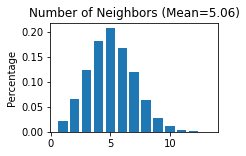

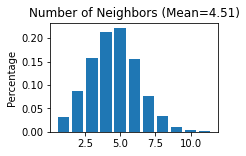

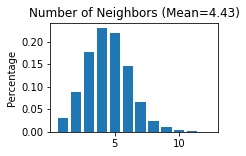

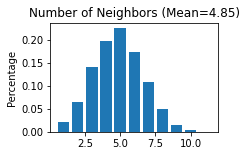

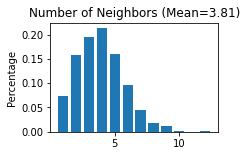

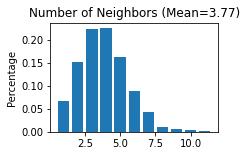

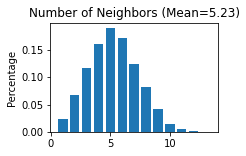

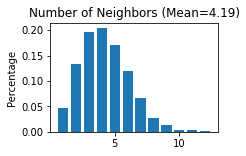

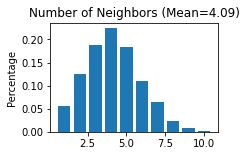

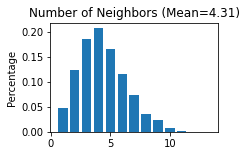

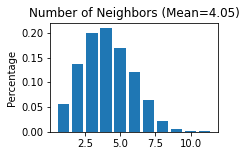

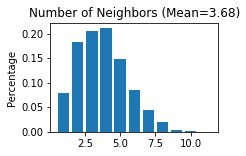

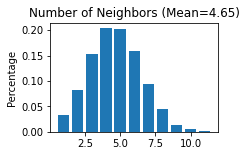

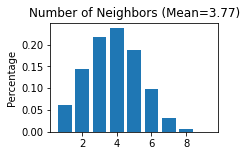

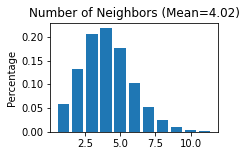

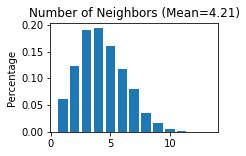

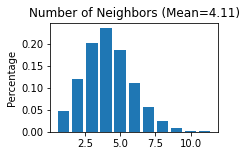

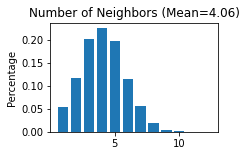

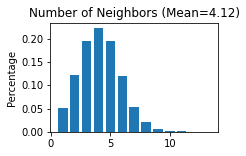

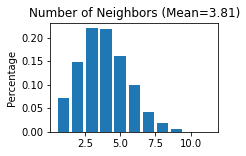

In [6]:
ids = [
        'fov1', 'fov2', 'fov3', 'fov4', 'fov5',
        'fov6', 'fov7', 'fov8', 'fov9', 'fov10',
        'fov11', 'fov12', 'fov13', 'fov14', 'fov15',
        'fov16', 'fov17', 'fov18', 'fov19', 'fov20'
]
img_names = [
        'F001', 'F002', 'F003', 'F004', 'F005',
        'F006', 'F007', 'F008', 'F009', 'F010',
        'F011', 'F012', 'F013', 'F014', 'F015',
        'F016', 'F017', 'F018', 'F019', 'F020',
]
adatas = list()
for id, name in zip(ids, img_names):
    adata = gen_adatas(opt.root, id, name)
    adatas.append(adata)

### 2.5 train a model
we skip this step in the tutorial because it took very long time (~10 hours using a 11GB 2080TI to train all 20 fovs), Instead, you can run the python script from terminal to train the model:

python3 train_nano_all.py --test_only 0 --save_path ../checkpoint/nanostring_train/ --seed 1234 --epochs 900 --lr 1e-3 
Here we load the trained model to show our results

### 2.6 inference the model
we saved the checkpoints in ../checkpoint/nanostring_all/all
The checkpoints can be download [here](https://purdue0-my.sharepoint.com/:u:/g/personal/tang385_purdue_edu/EZnAbrQm59dPtGKtSgSUBDABGGW86kh3ur6zZ2e-hVFWXQ?e=MWlkwB)

In [7]:
sp = os.path.join(opt.save_path, 'all')
adata = test_nano_fov(opt, adatas, hidden_dims=[512, 30],  n_epochs=opt.epochs, save_loss=True, 
      lr=opt.lr, random_seed=opt.seed, save_path=sp, ncluster=opt.ncluster)

/home/dao2/.local/lib/python3.8/site-packages/anndata-0.8.0rc1-py3.8.egg/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


../checkpoint/nanostring_all/all/final.pth
torch.Size([4966, 30])
torch.Size([4519, 30])
torch.Size([4497, 30])
torch.Size([4913, 30])
torch.Size([3674, 30])
torch.Size([3790, 30])
torch.Size([5103, 30])
torch.Size([4144, 30])
torch.Size([3849, 30])
torch.Size([4118, 30])
torch.Size([4007, 30])
torch.Size([3535, 30])
torch.Size([4707, 30])
torch.Size([3970, 30])
torch.Size([3944, 30])
torch.Size([3908, 30])
torch.Size([4087, 30])
torch.Size([4029, 30])
torch.Size([4121, 30])
torch.Size([3740, 30])


### 2.7 clustering the fovs

In [8]:
sc.pp.neighbors(adata, use_rep='pred')

def res_search(adata_pred, ncluster, seed, iter=200):
    start = 0; end =3
    i = 0
    while(start < end):
        if i >= iter: return res
        i += 1
        res = (start + end) / 2
        print(res)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        sc.tl.leiden(adata_pred, random_state=seed, resolution=res)
        count = len(set(adata_pred.obs['leiden']))
        if count == ncluster:
            print('find', res)
            return res
        if count > ncluster:
            end = res
        else:
            start = res
    raise NotImplementedError()

In [9]:
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

res = res_search(adata, opt.ncluster, opt.seed)

1.5
0.75
find 0.75


### 2.8 (optional) calculate ARI
if the dataset has annotaions, we can compute the ARI as the followings

In [10]:
seed_everything(opt.seed)
sc.tl.leiden(adata, resolution=res, key_added='leiden', random_state=opt.seed)
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['leiden'], obs_df['merge_cell_type'])
print('ARI: %.2f'%ARI)

ARI: 0.55


### 2.9 (optional) match the clusters to cell_types
we match the clusters and saved the results for further analysis

In [ ]:
cell_type = list(set(adata.obs['merge_cell_type']))
ground_truth = [i for i in range(len(cell_type))]
gt = np.zeros(adata.obs['merge_cell_type'].shape)
for i in range(len(ground_truth)):
    ct = cell_type[i]
    idx = (adata.obs['merge_cell_type'] == ct)
    gt[idx] = i
gt = gt.astype(np.int32)

pred = adata.obs['leiden'].to_numpy().astype(np.int32)
layers = []
cs = ['' for i in range(pred.shape[0])]
gt_cs = ['' for i in range(pred.shape[0])]
match = _hungarian_match(pred, gt, len(set(pred)), len(set(gt)))
colors = {'lymphocyte': '#E57272FF',
        'Mcell': '#FFCA27FF',
        'tumors': "#A6CEE3",
        'epithelial': "#D3E057FF",
        'mast': '#5B6BBFFF',
        'endothelial': '#26C5D9FF',
        'fibroblast': '#26A599FF',
        'neutrophil': '#B967C7FF'
    }
cs = ['' for i in range(pred.shape[0])]
gt_cs = ['' for i in range(pred.shape[0])]

for ind, j in enumerate(adata.obs['merge_cell_type'].tolist()):
    gt_cs[ind] = colors[j]

for outc, gtc in match:
    idx = (pred == outc)
    for j in range(len(idx)):
        if idx[j]:
            cs[j] = colors[cell_type[gtc]]
adata.obs['cmap'] = cs
adata.obs['gtcmap'] = gt_cs
adata.write('pdata/process_data_%s.h5ad'%opt.pretrain[:-4])
